In [1]:
!pip install -q flwr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.1/598.1 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-bigtable 2.30.0 requires google-api-core[grpc]<3.0.0,>=2.16.0, but you have google-api-core 1.34.1 which i

In [2]:
!pip install -U flwr

In [3]:
# --- Imports ---
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import gc
import flwr as fl
from flwr.client import NumPyClient
from flwr.common import Context
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
import time

# --- Load and prepare data ---
data = np.load("/kaggle/input/daicwoz-balanced/dataset_balanced.npz")
test_ids = np.load("/kaggle/input/daicwoz-balanced/test_ids (1).npy")

X_audio_test = data["X_audio_test"]
X_text_test = data["X_text_test"]
y_test = data["y_test"]

X_audio_dev = data["X_audio_dev"]
X_text_dev = data["X_text_dev"]
y_dev = data["y_dev"]

X_audio_train = data["X_audio_train"]
X_text_train = data["X_text_train"]
y_train = data["y_train"]

y_train = y_train.reshape(-1, 1)
y_dev = y_dev.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# --- Parameters ---
NUM_CLIENTS = 10
input_shape_audio = (378, 60)
input_shape_text = (378, 9)

# --- Build model ---
def build_model():
    input_audio = layers.Input(shape=input_shape_audio, name='mfcc_input')
    x_audio = layers.LSTM(60, return_sequences=True, recurrent_dropout=0.002,
                          bias_regularizer=regularizers.l1_l2(1e-4, 1e-4))(input_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(40, return_sequences=True, recurrent_dropout=0.002,
                          bias_regularizer=regularizers.l1_l2(1e-4, 1e-4))(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002,
                          bias_regularizer=regularizers.l1_l2(1e-4, 1e-4))(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)

    input_text = layers.Input(shape=input_shape_text, name='text_input')
    x_text = layers.Flatten()(input_text)

    x = layers.Concatenate()([x_audio, x_text])
    x = layers.Reshape((1, -1))(x)
    x = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(2e-4)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(15, activation='tanh')(x)
    x = layers.Dense(10, activation='tanh')(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs=[input_audio, input_text], outputs=output)

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def compile_model():
    model = build_model()
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(1e-5),
        loss=rmse,
        metrics=['accuracy', 'mae', rmse]
    )
    return model

def split_data(num_clients):
    size = len(y_train) // num_clients
    return [
        (X_audio_train[i * size : (i + 1) * size if i != num_clients - 1 else None],
         X_text_train[i * size : (i + 1) * size if i != num_clients - 1 else None],
         y_train[i * size : (i + 1) * size if i != num_clients - 1 else None])
        for i in range(num_clients)
    ]

client_datasets = split_data(NUM_CLIENTS)

# --- Global Metrics ---
global_metrics = {
    "accuracy": [],
    "mae": [],
    "rmse": [],
    "f1_score": [],
    "precision": [],
    "recall": [],
    "comm_bytes": [],
    "round_time_sec": []
}

def get_model_size(weights):
    return sum([w.nbytes for w in weights])

# --- Flower Client ---
class DepressionClient(NumPyClient):
    def __init__(self, model, X_audio_c, X_text_c, y_c):
        self.model = model
        self.X_audio_train = X_audio_c
        self.X_text_train = X_text_c
        self.y_train = y_c
        self.X_audio_test = X_audio_dev
        self.X_text_test = X_text_dev
        self.y_test = y_dev

    def get_parameters(self, config=None):
        return self.model.get_weights()

    def set_parameters(self, parameters):
        self.model.set_weights(parameters)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.fit(
            [self.X_audio_train, self.X_text_train],
            self.y_train,
            batch_size=32,
            epochs=2,
            verbose=0,
            shuffle=True,
        )
        return self.get_parameters(), len(self.y_train), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, acc, mae, rmse_val = self.model.evaluate(
            [self.X_audio_test, self.X_text_test], self.y_test, verbose=1
        )
        return float(loss), len(self.y_test), {
            "accuracy": float(acc),
            "mae": float(mae),
            "rmse": float(rmse_val)
        }

# --- Client App ---
def client_fn(context: Context):
    partition_id = int(context.node_config.get("partition-id", 0))
    model = compile_model()
    X_audio_c, X_text_c, y_c = client_datasets[partition_id]
    return DepressionClient(model, X_audio_c, X_text_c, y_c).to_client()

client_app = fl.client.ClientApp(client_fn=client_fn)

# --- Server App ---
def server_fn(context: Context) -> ServerAppComponents:
    model = compile_model()

    def evaluate_fn(server_round, parameters, _config):
        start = time.time()

        model.set_weights(parameters)
        y_pred = model.predict([X_audio_test, X_text_test])
        y_pred_labels = (y_pred > 0.5).astype(int)

        acc = accuracy_score(y_test, y_pred_labels)
        f1 = f1_score(y_test, y_pred_labels)
        prec = precision_score(y_test, y_pred_labels)
        rec = recall_score(y_test, y_pred_labels)
        mae_val = np.mean(np.abs(y_test - y_pred))
        rmse_val = np.sqrt(np.mean((y_test - y_pred) ** 2))

        bytes_per_round = get_model_size(parameters) * NUM_CLIENTS * 2
        round_time = time.time() - start

        global_metrics["accuracy"].append(acc)
        global_metrics["mae"].append(mae_val)
        global_metrics["rmse"].append(rmse_val)
        global_metrics["f1_score"].append(f1)
        global_metrics["precision"].append(prec)
        global_metrics["recall"].append(rec)
        global_metrics["comm_bytes"].append(bytes_per_round)
        global_metrics["round_time_sec"].append(round_time)

        print(f"\n\U0001F4CA Round {server_round}: Acc={acc:.4f}, F1={f1:.4f}, MAE={mae_val:.4f}, RMSE={rmse_val:.4f}, Bytes={bytes_per_round}, Time={round_time:.2f}s")

        tf.keras.backend.clear_session()
        gc.collect()

        return float(rmse_val), {
            "accuracy": float(acc),
            "f1_score": float(f1),
            "precision": float(prec),
            "recall": float(rec),
            "mae": float(mae_val),
            "rmse": float(rmse_val),
            "comm_bytes": bytes_per_round,
            "round_time_sec": round_time
        }

    strategy = FedAvg(
        fraction_fit=0.8,
        fraction_evaluate=0.5,
        min_fit_clients=NUM_CLIENTS,
        min_evaluate_clients=5,
        min_available_clients=NUM_CLIENTS,
        evaluate_fn=evaluate_fn,
    )

    return ServerAppComponents(strategy=strategy, config=ServerConfig(num_rounds=5))

server_app = ServerApp(server_fn=server_fn)

# --- Backend Resources ---
DEVICE = "cpu"
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

# --- Run Simulation ---
run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

2025-07-04 12:06:38.120656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751630798.369067      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751630798.443566      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-04 12:07:13.703865: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=551) 2025-07-04 12:07:23.310855: E external/local_xla/xla/stream_executor/c

44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step

📊 Round 0: Acc=0.5014, F1=0.5563, MAE=0.4993, RMSE=0.4998, Bytes=26125280, Time=8.32s


INFO :      initial parameters (loss, other metrics): 0.49981778860092163, {'accuracy': 0.5014367816091954, 'f1_score': 0.5562659846547314, 'precision': 0.5011520737327189, 'recall': 0.625, 'mae': 0.499294251203537, 'rmse': 0.49981778860092163, 'comm_bytes': 26125280, 'round_time_sec': 8.324632167816162}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=551) 2025-07-04 12:07:42.389616: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(ClientAppActor pid=550) 2025-07-04 12:07:42.383936: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step

📊 Round 1: Acc=0.4899, F1=0.5920, MAE=0.4995, RMSE=0.5004, Bytes=26125280, Time=6.05s


INFO :      fit progress: (1, 0.5003785490989685, {'accuracy': 0.4899425287356322, 'f1_score': 0.5919540229885057, 'precision': 0.4932950191570881, 'recall': 0.7399425287356322, 'mae': 0.4994719922542572, 'rmse': 0.5003785490989685, 'comm_bytes': 26125280, 'round_time_sec': 6.053420066833496}, 331.36954545599997)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


 1/44 ━━━━━━━━━━━━━━━━━━━━ 6:01 8s/step - accuracy: 0.0938 - loss: 0.5316 - mae: 0.5072 - rmse: 0.5076
 2/44 ━━━━━━━━━━━━━━━━━━━━ 20s 477ms/step - accuracy: 0.1250 - loss: 0.5326 - mae: 0.5082 - rmse: 0.5086
 3/44 ━━━━━━━━━━━━━━━━━━━━ 20s 491ms/step - accuracy: 0.1528 - loss: 0.5314 - mae: 0.5070 - rmse: 0.5074
 2/44 ━━━━━━━━━━━━━━━━━━━━ 31s 746ms/step - accuracy: 0.1250 - loss: 0.5326 - mae: 0.5082 - rmse: 0.5086
 1/44 ━━━━━━━━━━━━━━━━━━━━ 6:57 10s/step - accuracy: 0.0938 - loss: 0.5316 - mae: 0.5072 - rmse: 0.5076 [repeated 3x across cluster]
 2/44 ━━━━━━━━━━━━━━━━━━━━ 25s 601ms/step - accuracy: 0.1250 - loss: 0.5326 - mae: 0.5082 - rmse: 0.5086 [repeated 2x across cluster]
10/44 ━━━━━━━━━━━━━━━━━━━━ 21s 618ms/step - accuracy: 0.2304 - loss: 0.5307 - mae: 0.5061 - rmse: 0.5067 [repeated 30x across cluster]
18/44 ━━━━━━━━━━━━━━━━━━━━ 14s 570ms/step - accuracy: 0.2466 - loss: 0.5317 - mae: 0.5071 - rmse: 0.5077 [repeated 44x across cluster]
26/44 ━━━━━━━━━━━━━━━━━━━━ 8s 496ms/step - ac

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.3473 - loss: 0.5292 - mae: 0.5044 - rmse: 0.5052
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.3386 - loss: 0.5295 - mae: 0.5048 - rmse: 0.5055 [repeated 41x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step

📊 Round 2: Acc=0.5136, F1=0.4860, MAE=0.4997, RMSE=0.5014, Bytes=26125280, Time=6.51s


INFO :      fit progress: (2, 0.5013746023178101, {'accuracy': 0.5136494252873564, 'f1_score': 0.4859529233105543, 'precision': 0.5152979066022544, 'recall': 0.45977011494252873, 'mae': 0.4996858239173889, 'rmse': 0.5013746023178101, 'comm_bytes': 26125280, 'round_time_sec': 6.512145280838013}, 733.574951591)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 4016 MiB, 4 objects, write throughput 238 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=548) 2025-07-04 12:07:42.394328: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


 1/44 ━━━━━━━━━━━━━━━━━━━━ 5:50 8s/step - accuracy: 0.6875 - loss: 0.5325 - mae: 0.5077 - rmse: 0.5085
 2/44 ━━━━━━━━━━━━━━━━━━━━ 24s 572ms/step - accuracy: 0.6641 - loss: 0.5338 - mae: 0.5089 - rmse: 0.5098
 3/44 ━━━━━━━━━━━━━━━━━━━━ 22s 561ms/step - accuracy: 0.6788 - loss: 0.5320 - mae: 0.5071 - rmse: 0.5080
 1/44 ━━━━━━━━━━━━━━━━━━━━ 6:42 9s/step - accuracy: 0.6875 - loss: 0.5325 - mae: 0.5077 - rmse: 0.5085 [repeated 3x across cluster]
 2/44 ━━━━━━━━━━━━━━━━━━━━ 17s 407ms/step - accuracy: 0.6641 - loss: 0.5338 - mae: 0.5089 - rmse: 0.5098 [repeated 3x across cluster]
15/44 ━━━━━━━━━━━━━━━━━━━━ 12s 440ms/step - accuracy: 0.6002 - loss: 0.5338 - mae: 0.5087 - rmse: 0.5099 [repeated 48x across cluster]
20/44 ━━━━━━━━━━━━━━━━━━━━ 9s 397ms/step - accuracy: 0.5786 - loss: 0.5350 - mae: 0.5098 - rmse: 0.5110
21/44 ━━━━━━━━━━━━━━━━━━━━ 9s 397ms/step - accuracy: 0.5753 - loss: 0.5352 - mae: 0.5100 - rmse: 0.5112
21/44 ━━━━━━━━━━━━━━━━━━━━ 9s 423ms/step - accuracy: 0.5753 - loss: 0.5352 - m

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 7029 MiB, 7 objects, write throughput 288 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step

📊 Round 3: Acc=0.5050, F1=0.4720, MAE=0.5001, RMSE=0.5029, Bytes=26125280, Time=6.70s


INFO :      fit progress: (3, 0.502892792224884, {'accuracy': 0.5050287356321839, 'f1_score': 0.47203065134099625, 'precision': 0.5057471264367817, 'recall': 0.4425287356321839, 'mae': 0.5001075267791748, 'rmse': 0.502892792224884, 'comm_bytes': 26125280, 'round_time_sec': 6.700907468795776}, 1146.635627847)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 10041 MiB, 10 objects, write throughput 322 MiB/s.


 1/44 ━━━━━━━━━━━━━━━━━━━━ 6:06 9s/step - accuracy: 0.6875 - loss: 0.5292 - mae: 0.5037 - rmse: 0.5052
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.5395 - loss: 0.5318 - mae: 0.5064 - rmse: 0.5078
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5410 - loss: 0.5322 - mae: 0.5068 - rmse: 0.5082 [repeated 2x across cluster]
 2/44 ━━━━━━━━━━━━━━━━━━━━ 16s 399ms/step - accuracy: 0.6719 - loss: 0.5310 - mae: 0.5054 - rmse: 0.5070
 3/44 ━━━━━━━━━━━━━━━━━━━━ 15s 390ms/step - accuracy: 0.6875 - loss: 0.5285 - mae: 0.5030 - rmse: 0.5045
 1/44 ━━━━━━━━━━━━━━━━━━━━ 6:22 9s/step - accuracy: 0.6875 - loss: 0.5292 - mae: 0.5037 - rmse: 0.5052 [repeated 3x across cluster]
 2/44 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.6719 - loss: 0.5310 - mae: 0.5054 - rmse: 0.5070 [repeated 3x across cluster]
15/44 ━━━━━━━━━━━━━━━━━━━━ 12s 416ms/step - accuracy: 0.6127 - loss: 0.5327 - mae: 0.5067 - rmse: 0.5087 [repeated 46x across cluster]
19/44 ━━━━━━━━━━━━━━━━━━━━ 9s 379ms/step - accura

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.5452 - loss: 0.5321 - mae: 0.5058 - rmse: 0.5081


INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step

📊 Round 4: Acc=0.5050, F1=0.4579, MAE=0.5007, RMSE=0.5050, Bytes=26125280, Time=6.15s


INFO :      fit progress: (4, 0.5050153136253357, {'accuracy': 0.5050287356321839, 'f1_score': 0.45790715971675844, 'precision': 0.5060869565217392, 'recall': 0.41810344827586204, 'mae': 0.500740110874176, 'rmse': 0.5050153136253357, 'comm_bytes': 26125280, 'round_time_sec': 6.1477625370025635}, 1535.4406558050002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 17070 MiB, 17 objects, write throughput 342 MiB/s.


 1/44 ━━━━━━━━━━━━━━━━━━━━ 5:38 8s/step - accuracy: 0.6875 - loss: 0.5218 - mae: 0.4953 - rmse: 0.4978
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5472 - loss: 0.5325 - mae: 0.5062 - rmse: 0.5085 [repeated 34x across cluster]
 2/44 ━━━━━━━━━━━━━━━━━━━━ 15s 369ms/step - accuracy: 0.6719 - loss: 0.5245 - mae: 0.4978 - rmse: 0.5005
 3/44 ━━━━━━━━━━━━━━━━━━━━ 15s 378ms/step - accuracy: 0.6910 - loss: 0.5213 - mae: 0.4947 - rmse: 0.4973
 1/44 ━━━━━━━━━━━━━━━━━━━━ 5:42 8s/step - accuracy: 0.6875 - loss: 0.5218 - mae: 0.4953 - rmse: 0.4978 [repeated 3x across cluster]
 2/44 ━━━━━━━━━━━━━━━━━━━━ 17s 423ms/step - accuracy: 0.6719 - loss: 0.5245 - mae: 0.4978 - rmse: 0.5005
 2/44 ━━━━━━━━━━━━━━━━━━━━ 17s 425ms/step - accuracy: 0.6719 - loss: 0.5245 - mae: 0.4978 - rmse: 0.5005 [repeated 2x across cluster]
16/44 ━━━━━━━━━━━━━━━━━━━━ 10s 379ms/step - accuracy: 0.6199 - loss: 0.5297 - mae: 0.5025 - rmse: 0.5057 [repeated 46x across cluster]
20/44 ━━━━━━━━━━━━━━━━━━━━ 9s 388ms/step - accu

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step

📊 Round 5: Acc=0.5036, F1=0.4476, MAE=0.5013, RMSE=0.5077, Bytes=26125280, Time=6.63s


INFO :      fit progress: (5, 0.507678210735321, {'accuracy': 0.5035919540229885, 'f1_score': 0.44764188649080733, 'precision': 0.5045045045045045, 'recall': 0.40229885057471265, 'mae': 0.5012983083724976, 'rmse': 0.507678210735321, 'comm_bytes': 26125280, 'round_time_sec': 6.630550384521484}, 1972.7799419629998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


 1/44 ━━━━━━━━━━━━━━━━━━━━ 5:59 8s/step - accuracy: 0.6875 - loss: 0.5115 - mae: 0.4835 - rmse: 0.4875
 2/44 ━━━━━━━━━━━━━━━━━━━━ 16s 382ms/step - accuracy: 0.6719 - loss: 0.5155 - mae: 0.4873 - rmse: 0.4916
 3/44 ━━━━━━━━━━━━━━━━━━━━ 15s 369ms/step - accuracy: 0.6910 - loss: 0.5116 - mae: 0.4835 - rmse: 0.4877
 1/44 ━━━━━━━━━━━━━━━━━━━━ 5:40 8s/step - accuracy: 0.6875 - loss: 0.5115 - mae: 0.4835 - rmse: 0.4875 [repeated 3x across cluster]
 2/44 ━━━━━━━━━━━━━━━━━━━━ 17s 415ms/step - accuracy: 0.6719 - loss: 0.5155 - mae: 0.4873 - rmse: 0.4916 [repeated 3x across cluster]
16/44 ━━━━━━━━━━━━━━━━━━━━ 10s 377ms/step - accuracy: 0.5995 - loss: 0.5259 - mae: 0.4971 - rmse: 0.5020 [repeated 51x across cluster]
18/44 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5928 - loss: 0.5271 - mae: 0.4981 - rmse: 0.5031
19/44 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step - accuracy: 0.5899 - loss: 0.5275 - mae: 0.4986 - rmse: 0.5036
20/44 ━━━━━━━━━━━━━━━━━━━━ 8s 372ms/step - accuracy: 0.5869 - loss: 0.5281 - m

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 2011.14s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5224485993385315
INFO :      		round 2: 0.522769033908844
INFO :      		round 3: 0.5237472653388977
INFO :      		round 4: 0.5255953669548035
INFO :      		round 5: 0.5283398032188416
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.49981778860092163
INFO :      		round 1: 0.5003785490989685
INFO :      		round 2: 0.5013746023178101
INFO :      		round 3: 0.502892792224884
INFO :      		round 4: 0.5050153136253357
INFO :      		round 5: 0.507678210735321
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.5014367816091954),
INFO :      	              (1, 0.4899425287356322),
INFO :      	              (2, 0.5136494252873564),
INFO :      	              (3, 0.5050287356321839),
INFO :      	              (4, 0.5050287356321839),
IN

43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5485 - loss: 0.5303 - mae: 0.5008 - rmse: 0.5064 [repeated 35x across cluster]
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.5462 - loss: 0.5302 - mae: 0.5007 - rmse: 0.5063


In [4]:
# --- Save Metrics ---
pd.DataFrame(global_metrics).to_csv("fl_global_metrics.csv", index=False)

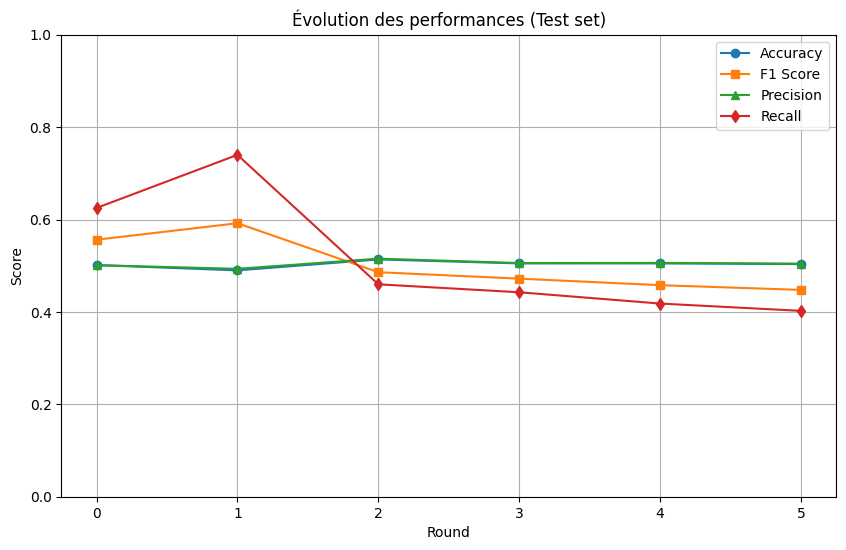

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les métriques
df = pd.read_csv("fl_global_metrics.csv")

# Tracer les courbes de performance
plt.figure(figsize=(10, 6))
plt.plot(df["accuracy"], label="Accuracy", marker="o")
plt.plot(df["f1_score"], label="F1 Score", marker="s")
plt.plot(df["precision"], label="Precision", marker="^")
plt.plot(df["recall"], label="Recall", marker="d")
plt.title("Évolution des performances (Test set)")
plt.xlabel("Round")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


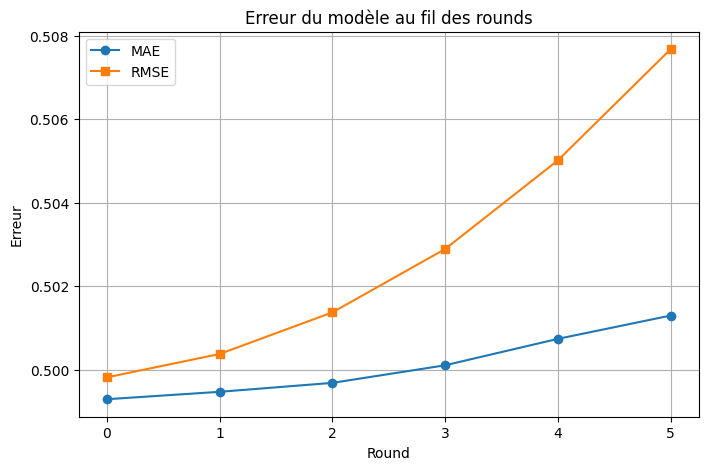

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(df["mae"], label="MAE", marker="o")
plt.plot(df["rmse"], label="RMSE", marker="s")
plt.title("Erreur du modèle au fil des rounds")
plt.xlabel("Round")
plt.ylabel("Erreur")
plt.legend()
plt.grid(True)
plt.show()


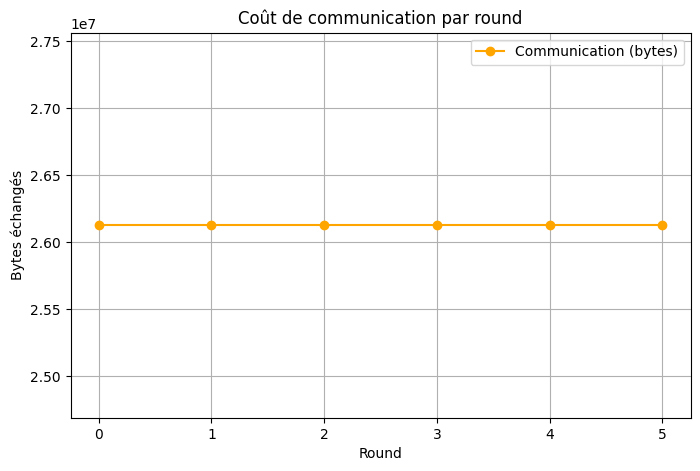

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(df["comm_bytes"], label="Communication (bytes)", color="orange", marker="o")
plt.title("Coût de communication par round")
plt.xlabel("Round")
plt.ylabel("Bytes échangés")
plt.grid(True)
plt.legend()
plt.show()


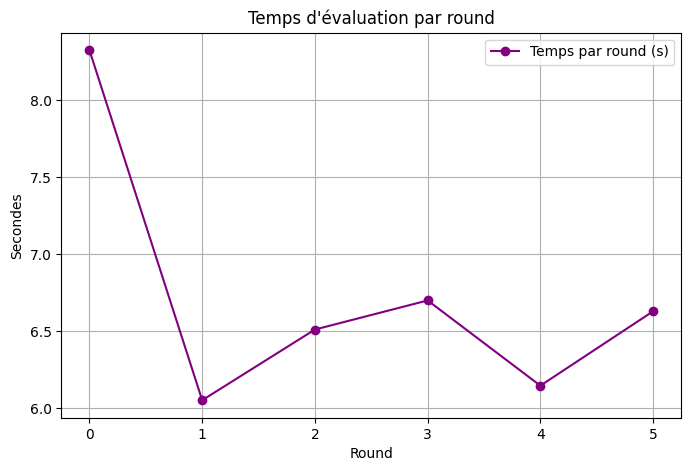

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(df["round_time_sec"], label="Temps par round (s)", color="purple", marker="o")
plt.title("Temps d'évaluation par round")
plt.xlabel("Round")
plt.ylabel("Secondes")
plt.grid(True)
plt.legend()
plt.show()


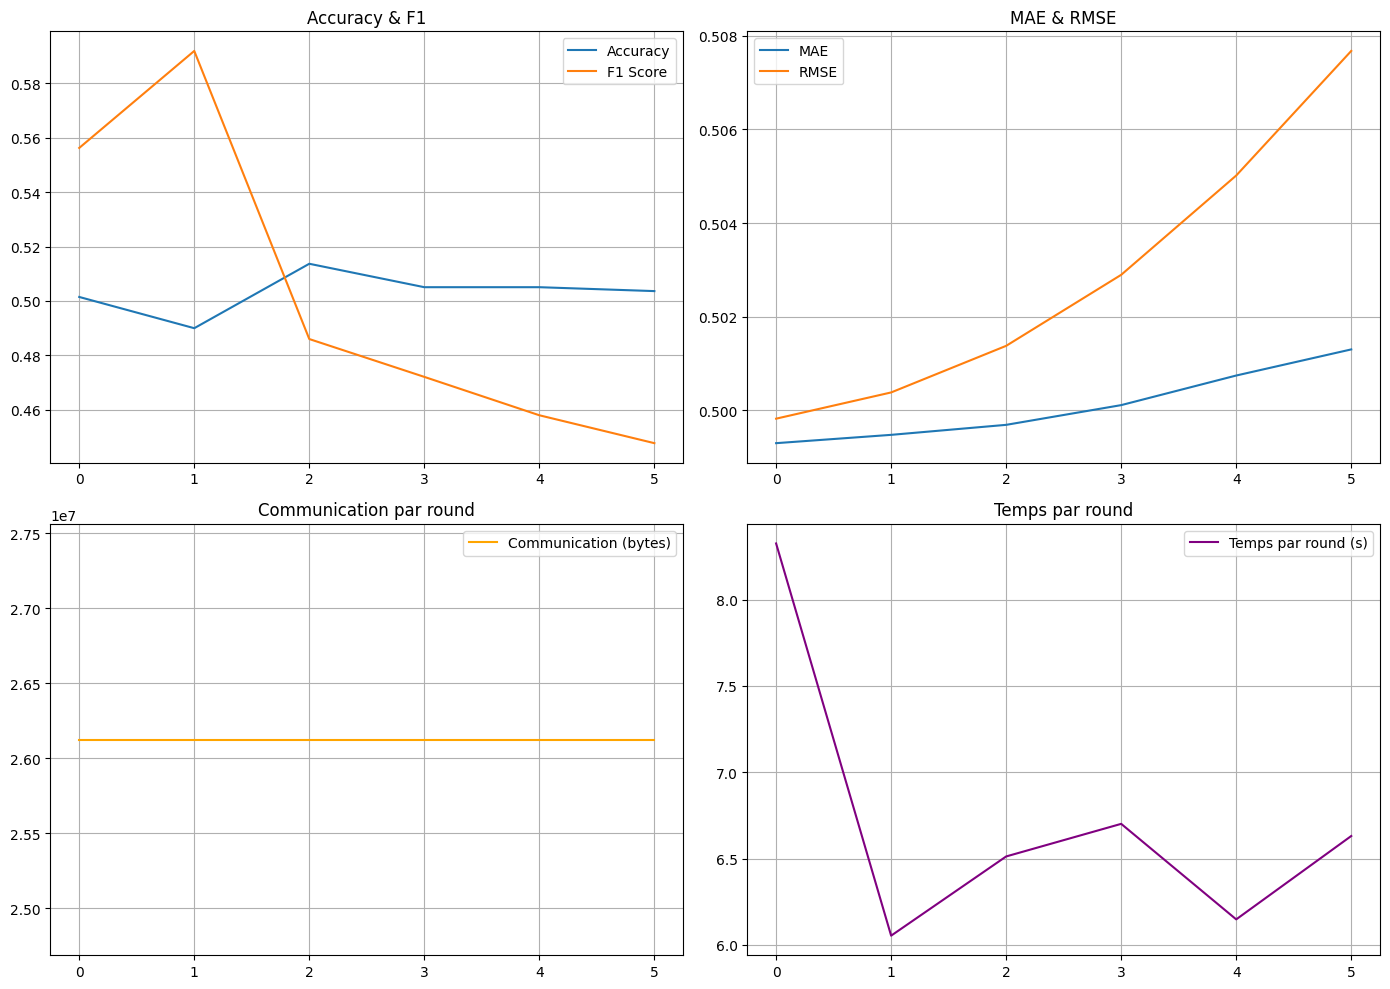

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy & F1
axs[0, 0].plot(df["accuracy"], label="Accuracy")
axs[0, 0].plot(df["f1_score"], label="F1 Score")
axs[0, 0].set_title("Accuracy & F1")
axs[0, 0].legend()
axs[0, 0].grid(True)

# MAE & RMSE
axs[0, 1].plot(df["mae"], label="MAE")
axs[0, 1].plot(df["rmse"], label="RMSE")
axs[0, 1].set_title("MAE & RMSE")
axs[0, 1].legend()
axs[0, 1].grid(True)

# Communication
axs[1, 0].plot(df["comm_bytes"], label="Communication (bytes)", color="orange")
axs[1, 0].set_title("Communication par round")
axs[1, 0].legend()
axs[1, 0].grid(True)

# Round Time
axs[1, 1].plot(df["round_time_sec"], label="Temps par round (s)", color="purple")
axs[1, 1].set_title("Temps par round")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()
